In [1]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ConstantKernel, RBF
from sklearn.metrics import mean_squared_error

- В склерне оптимальные параметры ядра ищутся не градиентным спуском, а в gpytorch градиентным спуском как внутри pytorch - в этом главное отличие 

- Лосс, который пишется у гпр - это -log likelyhood loss для параметров, которые мы обучаем

- Мы добавляем какие-то параметры, чтобы не делать операции $O(N^3)$, а сделать несколько шагов оптимизации параметров вместе того, чтобы полностью точно считать обратную к K

- в склерне дефолтный кернел - это конст кернел * RBF - короче там 2 параметра обучается

In [2]:
def make_predictions_and_plot(model, X_matrices=None, Y_target=None, figsize=(30, 20), fontsize=20, criterion=nn.MSELoss(), data=None, same_axis=False):
    '''

    Строит предсказанную и тагрет зависимости

    Можно подавать либо отлельно X_matrices, Y_target либо подать датасет из тьюплов: (X, f_k_dim, f_3d, A_pinv)

    Будет подаваться 3 итерируемых объекта: набор(батч или кусок датасета) из "матриц", предсказания, таргеты

    Качество

    '''

    if data:
        X_matrices, Y_target, *_ = list(map(lambda x: torch.stack(x), list(zip(*data))))

        
    Y_pred = model.predict(X_matrices)
    names = ['predicted', 'target']
    Ys = [Y_pred, Y_target]
    metric = mean_squared_error(Y_pred, Y_target)

    plt.figure(figsize=figsize)
    fig = plt.gcf()
    fig.suptitle(f'Metric: {metric}', fontsize=22)

    for (i, name) in enumerate(names):
        if not same_axis:
            plt.subplot(1, 2, i + 1)

        plt.scatter(X_matrices.squeeze(), Ys[i].squeeze(), label='Y(X)')

        plt.xlabel('X', fontsize=18)
        plt.ylabel('Y', fontsize=18)
        plt.legend(loc='best', fontsize=fontsize)
        plt.title(f'{name}', fontsize=18)
        plt.grid(alpha=0.4)

    plt.show()

In [3]:
def create_dataloaders(train_dataset, val_dataset, train_bs=64, val_bs=64, fold=None):
    '''

    Returns train_loader, val_loader

    fold: will be used in cross validation, when I will implement it

    '''
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_bs, shuffle=True)

    val_loader = DataLoader(dataset=val_dataset, batch_size=val_bs, shuffle=False)

    return train_loader, val_loader

In [4]:
def recieve_loaders(take_one_projection_for_data=None, path=None, cut_size=None):
    '''
    returns: (train_data, val_data, train_loader, val_loader), if u pass path -> returns loader from tensor dataset from
    '''
    if path:
        N = int(path.split('_')[0])
        K = int(path.split('_')[-1].split('.')[0])

        dataset = torch.load(str(N) + '_dataset_K_' + str(K) + '.pt')
        dataset = [(elem[0], elem[1], elem[2], elem[3]) for elem in dataset]

        if take_one_projection_for_data:
 
            dataset = [(elem[0], elem[1][take_one_projection_for_data - 1].unsqueeze(dim=0), elem[2], elem[3]) for elem in dataset]

        train_data, val_data = train_test_split(dataset, test_size=0.33, random_state=42)
        if cut_size:
            train_data = train_data[:cut_size]
            val_data = val_data[:cut_size]
        train_dataloader, val_dataloader = create_dataloaders(train_data, val_data)
        return train_data, val_data, train_dataloader, val_dataloader
    
    # Ниже идет типо генерация искусственных данных
    X = []
    Y = []
    for _ in range(500):
        # X = (torch.rand(1)).squeeze().unsqueeze(dim=0)
        x = (torch.rand(K))
        y = function(x)
        X.append(x)
        Y.append(y)

    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, random_state=42, train_size=0.8)

    X_train = torch.stack(X_train)
    X_val = torch.stack(X_val)
    Y_train = torch.stack(Y_train)
    Y_val = torch.stack(Y_val)

    train_data = TensorDataset(X_train, Y_train)
    val_data = TensorDataset(X_val, Y_val)

    train_dataloader = DataLoader(train_data, batch_size=128)
    val_dataloader = DataLoader(val_data, batch_size=128)

    return train_data, val_data, train_dataloader, val_dataloader

In [15]:
def formate_data_for_sklearn(data, size_cut=1):

    X = [elem[0].detach().numpy() for elem in data[:len(data) * size_cut]]
    Y = [elem[1].detach().numpy() for elem in data[:len(data) * size_cut]]

    X = np.stack(X)
    Y = np.stack(Y)
    return X, Y

In [16]:
my_kernel = ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) * RBF(1.0, length_scale_bounds=(1e-7, 1e2))  # пока фиксированные параметры
my_kernel

1**2 * RBF(length_scale=1)

In [17]:
path = '4_dataset_K_3.pt'

K = path

data = torch.load(path)

train_data, val_data, *_ = recieve_loaders(path=path, take_one_projection_for_data=0)

train_X, train_Y = formate_data_for_sklearn(train_data)
val_X, val_Y = formate_data_for_sklearn(val_data)

In [13]:
gpr = GaussianProcessRegressor(kernel=my_kernel, random_state=0, n_restarts_optimizer=10)
gpr.fit(train_X, train_Y)

Y_pred = gpr.predict(val_X, return_std=False)

KeyboardInterrupt: 

In [9]:
mean_squared_error(val_Y, Y_pred)

1.346249406417536

In [10]:
gpr.score(val_X, val_Y)

-0.45625561980744617

ValueError: x and y must be the same size

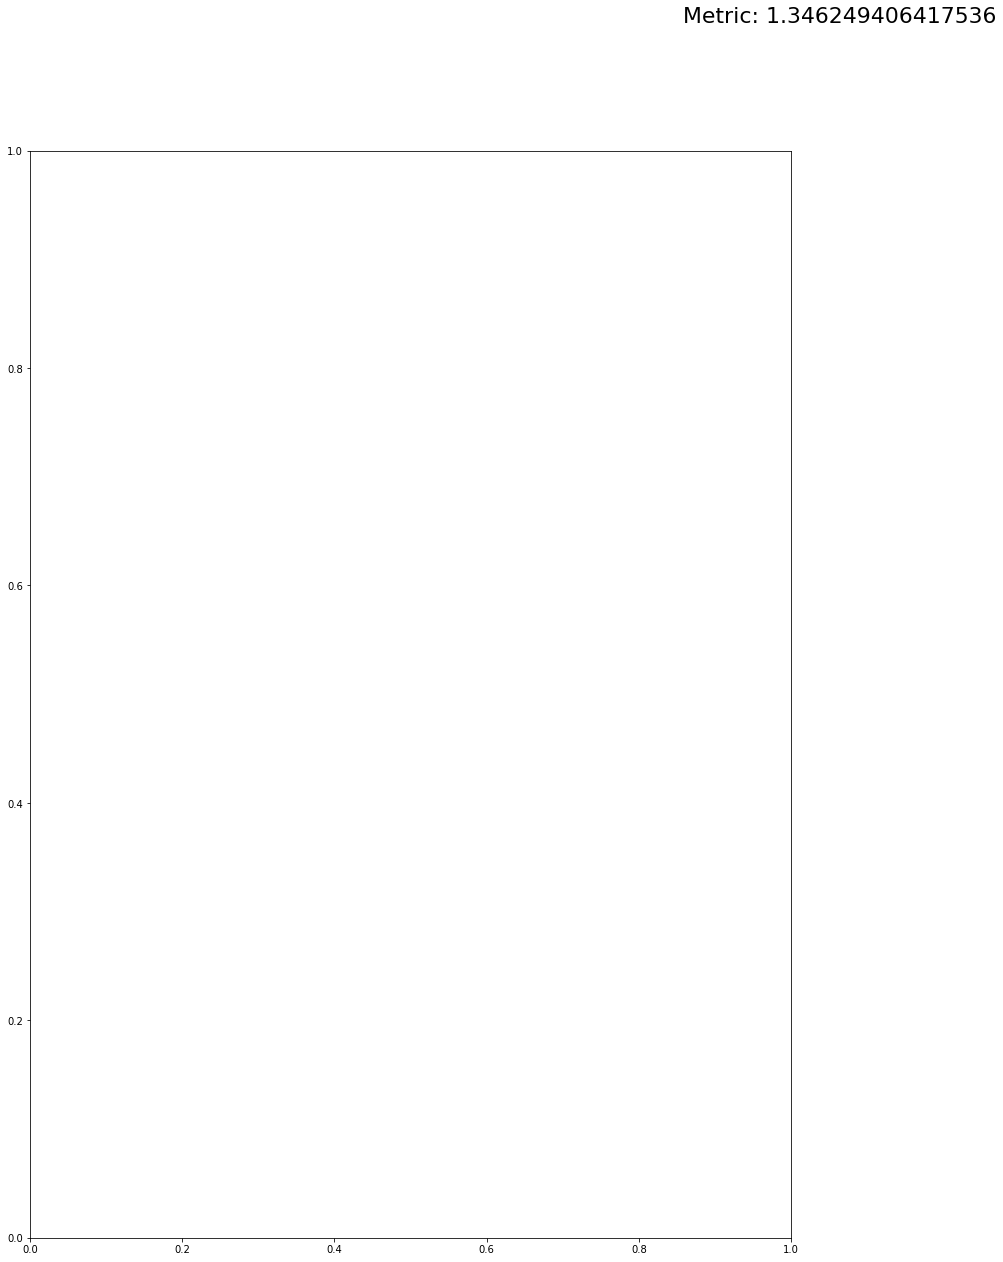

In [11]:
make_predictions_and_plot(model=gpr, data=val_data, same_axis=False)

In [ ]:
gpr.kernel.get_params()

{'k1': 1**2,
 'k2': RBF(length_scale=1),
 'k1__constant_value': 1.0,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 1.0,
 'k2__length_scale_bounds': (1e-05, 100000.0)}